<a href="https://www.kaggle.com/code/bigbuckles/building-a-neural-net-for-the-mnist-dataset?scriptVersionId=166701978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#|default_exp app
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The goal of this notebook is to create a neural net capable of reading numbers from the MNIST dataset. This will be a continuation of my previous notebook "Building an Image Classifier".

In [2]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook
#|export
!pip install -Uqq fastai


In [3]:
#|export
from fastai.vision.all import *

import cv2
matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [6]:
(path/'training').ls()

(#10) [Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/0')]

In [7]:
zeroes = (path/'training'/'0').ls().sorted()
ones = (path/'training'/'1').ls().sorted()
twos = (path/'training'/'2').ls().sorted()
threes = (path/'training'/'3').ls().sorted()
fours = (path/'training'/'4').ls().sorted()
fives = (path/'training'/'5').ls().sorted()
sixes = (path/'training'/'6').ls().sorted()
sevens = (path/'training'/'7').ls().sorted()
eights = (path/'training'/'8').ls().sorted()
nines = (path/'training'/'9').ls().sorted()

In [8]:
im0_path = zeroes[0]
im0 = Image.open(im0_path)
im0

In our previous notebook, we first used distance from a mean image as a baseline prediciton model to compare our future models against. Let's begin by setting that up.

First we will need to create a mean image for each digit. We can accomplish this by stacking all of the images of like digits together and then averaging their pixel values. 

In [9]:
zeroes_tensor = [tensor(Image.open(o)) for o in zeroes]

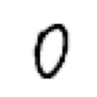

In [10]:
show_image(zeroes_tensor[1]);

We have successfully stacked our zero digits into a tensor, we could repeat this line by line for the other digits, however, it would be more efficient to loop over all the various digits and stack them. To do this we can create a dictionary where the digit can serve as the keyword to access it's respective tensor. Let's implement that below:

In [11]:
train = (path/'training').ls().sorted()

tensors = {}

for path in train:
    tensors[path.name] = [tensor(Image.open(o)) for o in path.ls()]

We can now check if this did indeed accomplish what we were hoping it would by looking at an image from our tensor dictionary much as we did for the zeroes tensor we created.

<Axes: >

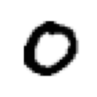

In [12]:
show_image(tensors['0'][1])

It looks like it's working. Now we can begin on taking the average of the various stacked images. We will do this much like we did in generating the tensors above by creating a dicitonary and looping through our tensors dicitonary we created. we can use `tensors.keys()` to loop over this dictionary.

In [13]:
stacked_tensors = {}

for entry in tensors.keys():
    stacked_tensors[entry] = torch.stack(tensors[entry]).float()/255

Let's check if we have a mean image just as we did in the previous notebook.

<Axes: >

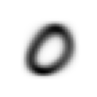

In [14]:
show_image(stacked_tensors['0'].mean(0))

The next step we did in the previous notebook where we were only comparing 0s and 7s was to take the distance of a single zero from the average zero. Let's do that now.

In [15]:
mean_0 = stacked_tensors['0'].mean(0)
a_0 = stacked_tensors['0'][0]
dist_0_abs =(a_0 - mean_0).abs().mean()
dist_0_sqrt = ((a_0 - mean_0)**2).mean().sqrt()
dist_0_abs, dist_0_sqrt

(tensor(0.1143), tensor(0.1950))

Just as last time let's compare this distance to that of another digit, let's say 8.

In [16]:
a_8 = stacked_tensors['8'][0]
dist_8_abs =(a_8 - mean_0).abs().mean()
dist_8_sqrt = ((a_8 - mean_0)**2).mean().sqrt()
dist_8_abs, dist_8_sqrt

(tensor(0.1727), tensor(0.3004))

We can also do this operation using PyTorch.

In [17]:
F.l1_loss(a_8.float(), mean_0), F.mse_loss(a_8, mean_0).sqrt()

(tensor(0.1727), tensor(0.3004))

Just as last time we can see that the distance values are larger for eight than they are for zero indicating that the zero digit is closer to an average zero than the eight is. This is a good proof of concept, however, this is the same as we have done before. To expand on this, let's find the distance of every digit from the average zero. Let's begin by sepeating our training data into a training and validation set. This way we can use a validation set to test against the mean calculated with the training set.

In [18]:
train = {}
valid = {}

We want to have 80% of our data in the training set and 20% in the validation set. We can do this by finidng the length of each stacked tensor and adding 80% of that to the training set then the other 20% to validation. We want to randomly select these and we can use `torch.utils.data.random_split` to accomplish this. This PyTorch function takes in a dataset and lengths by which to split it then randomly splits said dataset into those lengths. We can use a seed to ensure that it will split the same images from the dataset everytime.

In [19]:
for key in stacked_tensors.keys():
    length = (len(stacked_tensors[key]))
    train_size = math.floor(length*0.8)
    valid_size = length - train_size
    generator = torch.Generator().manual_seed(42)
    [train_split, valid_split] = torch.utils.data.random_split(stacked_tensors[key], 
                                                               [train_size, valid_size], generator)
    train_data = [stacked_tensors[key][i] for i in train_split.indices]
    valid_data = [stacked_tensors[key][i] for i in valid_split.indices]
    train_tensor = torch.stack(train_data)
    valid_tensor = torch.stack(valid_data)
    train[key] = train_tensor
    valid[key] = valid_tensor

Now we can find the means of every digit and create another dicitonary of means.

In [20]:
means = {}
for key in train.keys():
    means[key] = train[key].mean(0)

<Axes: >

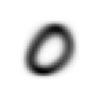

In [21]:
show_image(means['0'])

We now have average digits for every digit we are interested in. Let's now define a function that intakes a digit image, subtracts it from each mean digit and determines which average image it is closest to.

In [22]:
def classify_by_mean(image_tensor):
    digits = []
    for img in image_tensor:
        distances = {}
        for key in means.keys():
            distances[key] = (img - means[key]).abs().mean((-1,-2))
        sorted_list = sorted(list(distances.items()), key=lambda x:x[1])
        digits.append(sorted_list[0][0])
    return digits

A lot happened in this function. Let's break it down line by line:
* `def clasiffy_by_mean(image_tensor)` This takes in an image tensor into the function
* `digits = []` This creates an array of our digits, This array will be returned with the predicted values for each image input into the function
* `for img in image_tensor:` This loops through each input image in the image tensor
* `distances = {}` This creates a dictionary of distances
* `for key in means.keys` This loops through the mean images of each digit
* `distances[key] = (img - means[key]).abs().mean((-1,-2))` This takes the distances the image being looked at is from the current mean image being sampled
* `sorted_list = sorted(list(distances.items()), key=lambda x:x[1])` This creates a sorted list of all of the distances for the current image from the various mean images in ascending order> meaning the closest digit will be the first in the list
* `digits.append(sorted_list[0][0]` This appends the smallest digit in the sorted list of the image being examined
* `return digits` The function outputs an array of the predictions from the model for every input image in the image tensor


In [23]:
predictions = {}
accuracy = {}

for k in means.keys():
    predictions[k] = classify_by_mean(valid[k])
    acc = sum(1 if pred == k else 0 for pred in predictions[k])/(len(predictions[k]))
    accuracy[k] = acc
    
    
for digit, acc in accuracy.items():
    print (digit, round(acc,4))

0 0.8228
1 0.9993
2 0.4413
3 0.5844
4 0.6467
5 0.3069
6 0.7627
7 0.7821
8 0.386
9 0.6807


We can see an output of the accuracies for predictions of each digit. 1 has the highest accuracy while 5 has the lowest. Let's also determine our overalla accuracy.

In [24]:
total = 0
for digit, acc in accuracy.items():
    total += acc
total_accuracy = total/10
print(total_accuracy)

0.6412748764558382


Our average model has an overall accuracy of ~64%. We can hopeully do better than this by creating a learning model. Let's list out the initial set up steps we will need to do this.

* Create a training set and a validation set from the provided validation set (80/20 split)
    * We can accomplish this by adding all images in the training set into a tensor, shuffling the images within that tensor, and then using the first 80% as our training set and the remaining 20% as our validation set. 
* Change the image tensors from a rank 3 tensor to a rank 2 tensor by changing them from a 28*28 matrix to a 1*784 vector to allow for matrix multiplication
* Finally we will need to create tuples of image and label for both the training set and the validation set.

Let's start by creating our training and validation sets.


In [25]:
path = untar_data(URLs.MNIST)
image_path =  (path/'training').ls().sorted()
tensors = [(tensor(Image.open(o)), int(path.name)) for path in image_path for o in path.ls()]

<Axes: >

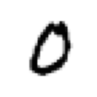

In [26]:
show_image(tensors[0][0])

We now have a tensor that has all of our images. Let's now shuffle that data and then divide it into our training and validation set.

<Axes: >

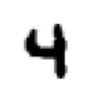

In [27]:
np.random.shuffle(tensors)
index = math.floor(0.8 * len(tensors))
training_set = tensors[:index]
validation_set = tensors[index:]
show_image(tensors[1][0])

We now have our training and validation sets. Next let's change these matrices to vectors.

In [28]:
#|export
train_x = torch.cat([training_set[i][0].view(-1, 784).float()/255 for i in range(len(training_set))])
train_y = tensor([training_set[i][1] for i in range(len(training_set))])
valid_x = torch.cat([validation_set[i][0].view(-1, 784).float()/255 for i in range(len(validation_set))])
valid_y = tensor([validation_set[i][1] for i in range(len(validation_set))])

Finally let's create datasets from our `train_x` and `train_y` as well as `valid_x` and `valid_y`.

In [29]:
#|export
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

Now we can start step one of the seven step learning model process by initializing our parameters.

In [30]:
def init_parameters(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

We can now use this function to initialize our weights and biases

In [31]:
weights = init_parameters(((28*28), 10))
bias = init_parameters((1, 10))

We initialize our weights variable with 784 weights for each pixel of the image as well as an additional 9 for each possible digit. Our bias also has this. Let's see what our current model looks like.

In [32]:
pred = (train_x[0]*weights.T).sum() + bias
pred

tensor([[-16.3847, -16.3928, -18.4394, -18.3666, -17.2397, -16.7509, -17.2923,
         -17.3923, -17.5444, -16.8538]], grad_fn=<AddBackward0>)

These numbers are not very helpful to us and do not represent a probability distribution. Through some googling it was reccomended that a `softmax` function be used. This function converts a vector of $K$ real numbers and converts it to a probability distribution of $K$ possible outcomes. We can implement this in our prediciton.

In [33]:
def linear_model_1(xb): return xb@weights + bias
preds = linear_model_1(train_x)
preds = F.softmax(preds, dim=1)
torch.set_printoptions(sci_mode=False)
preds[2]

tensor([    0.0000,     0.0000,     0.0000,     0.0000,     0.9713,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0287],
       grad_fn=<SelectBackward0>)

Let's see what the accuracy of our model is over all of the training images.

In [34]:
corrects = tensor([torch.argmax(preds[i]) == train_y[i] for i in range(len(preds))])
acc_percentage = corrects.float().mean().item()

corrects, acc_percentage

(tensor([False, False, False,  ..., False, False, False]), 0.11152083426713943)

Our model currently has an accuracy of just under 12% which is not very good. Certainly worse than our mean image prediction. From the previous notebook we can recall that using accuracy as a loss function is not a very good method for machine learning because the graph for accuracy only has significant slopes near the inflection points where it goes from one number to another. Due to this we will need to choose a different loss function. In the "Going Deeper" section of chapter 4 of the fastai book they use a loss funciton called cross entropy. This function works by measuring the ddifference between the discovered probability distribution and the predicted distribution. To use cross entropy in PyTorch we can write a function like this: `loss = F.cross_entropy(predictions, target.squeeze())`. Let's try implementing this loss function into our model and see if it improves our results.

In [35]:
#|export
def mnist_loss(predicitons, targets):
    loss = F.cross_entropy(predicitons, targets.squeeze())
    return loss

Now that we have a loss function, lets set up a mini batch to run through it.

In [36]:
batch = train_x[:4]
batch.shape

preds = linear_model_1(batch)
preds

tensor([[-12.0176,   4.9332, -10.1090,  -8.5564, -12.2630,  -6.5977,   9.7703,
           2.7590,  -5.8863,  16.0288],
        [-14.9888,   8.4844,   2.1466, -29.8430,  10.4089, -11.7095,   7.1999,
         -11.2882,  -8.1596,  19.7073],
        [ -6.1546,   0.9124,  -8.2309,   3.1453,  13.3657, -11.4636,  -5.2643,
          -1.4391,  -6.6337,   9.8429],
        [-16.3256,   5.9632, -14.0703,   0.9506,  11.0662, -13.2208,   9.6617,
          -8.2228,   3.0911,   9.4772]], grad_fn=<AddBackward0>)

Abd then test our loss function

In [37]:
loss = mnist_loss(preds, train_y[:4])
print(loss)

tensor(18.7991, grad_fn=<NllLossBackward0>)


Finally we can calculate the gradients of the loss function

In [38]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad.shape

(torch.Size([784, 10]), tensor(    0.0000), torch.Size([1, 10]))

Let's put that gradient calculation into a function we can use later. We can actually reuse the function we created in our previous notebook for this.

In [39]:
def calc_grad(x_batch, y_batch, model):
    preds = model(x_batch)
    loss = mnist_loss(preds, y_batch)
    loss.backward()

calc_grad(batch, train_y[:4], linear_model_1)
weights.grad.mean(), bias.grad

(tensor(    0.0000),
 tensor([[    -0.5000,      0.0021,      0.0000,      0.0000,      0.3291,
              -0.5000,      0.0853,     -0.5000,      0.0001,      1.0834]]))

The following example was done in the previous notebook and bares repeating as it is crucial to understand for the next step, if we call the cal_grad funciton again it will add on to our existing gradients like such:

In [40]:
calc_grad(batch, train_y[:4], linear_model_1)
weights.grad.mean(), bias.grad

(tensor(    0.0000),
 tensor([[    -0.7500,      0.0032,      0.0000,      0.0000,      0.4936,
              -0.7500,      0.1279,     -0.7500,      0.0002,      1.6251]]))

To avoid this we need to set the wights and bias gradients to zero/


In [41]:
weights.grad.zero_()
bias.grad.zero_()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

The only remaining step is to now update the weights and biases using the gradient and learning rate. Once again, as above, we will have to tell PyTorch that we don't want to take the gradient at this step. We can do this if we assign to the `data` attribute of a tensor then PyTorch won't take the gradient of that step.

In [42]:
def train_epoch(model, lr, params):
    for x_batch, y_batch in dl:
        calc_grad(x_batch, y_batch, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

No let's create our human readable metric just as we did with our previous smaller model.

In [43]:
#|export

def calculate_accuracy(preds, targets):
    return torch.argmax(preds, dim=1) == targets

def batch_accuracy(x_batch, y_batch):
    preds = F.softmax(x_batch, dim=1)
    correct = calculate_accuracy(preds, y_batch)
    return correct.float().mean()

In [44]:
batch_accuracy(linear_model_1(batch), train_y[:4])

tensor(0.)

Let's now find the accuracy for an entire epoch

In [45]:
#|export
# def validate_epoch(model):
#     accs = [batch_accuracy(model(x_batch), y_batch) for x_batch, y_batch in valid_dl]
#     return round(torch.stack(accs).mean().item(), 4)
def validate_epoch(model):
    accs = []
    for x_batch, y_batch in valid_dl:
        accs.append(batch_accuracy(model(x_batch), y_batch))
    return round(torch.stack(accs).mean().item(), 4)

Before we can implement this we need to create our `valid_dl` DataLoader. We might as well create our training DataLoader as well during this step.

In [46]:
#|export
dl = DataLoader(dset, batch_size = 256)
valid_dl =DataLoader(valid_dset, batch_size = 256)

x_batch, y_batch = first(dl)

In [47]:
validate_epoch(linear_model_1)

0.1075

9.6% for the entire model with our randomly initialized parameters, let's see if that improves with another epoch.

In [48]:
lr = 1 
params = weights, bias
train_epoch(linear_model_1, lr, params)
validate_epoch(linear_model_1)

0.8245

After just one epoch the accuracy has shot up to 83.57%, not bad. Lets create a function to loop through several epochs and see how accurate we can get the model.

In [49]:
for i in range(20):
    lr = 1 
    params = weights, bias
    train_epoch(linear_model_1, lr, params)
    print(validate_epoch(linear_model_1), end=' ')

0.857 0.8691 0.877 0.8823 0.8849 0.8885 0.8913 0.8934 0.8951 0.8965 0.898 0.8995 0.9006 0.9015 0.902 0.9032 0.9041 0.9051 0.9051 0.9049 

All the way up to 90% after only 20 epochs. Not bad, however, by adding a nonlinear function between our layers we can increase this accuracy even more. First let's rewrite our linear function takling advantage of the existing linear function within PyTorch.

In [50]:
#|export
simple_nnet = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)

Now lets create a DataLoaders for PyTorch to use with this simple neural net we are creating.


In [51]:
#|export
dls = DataLoaders(dl, valid_dl)

And now create our learning object to make use of these.

In [52]:
#|export
learn = Learner(dls, simple_nnet, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [53]:
#|export
learn.fit(10, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.553621,0.438275,0.882417,00:01
1,0.369057,0.355193,0.901417,00:00
2,0.326493,0.325860,0.909250,00:00
3,0.303550,0.307495,0.913333,00:00
4,0.286071,0.292228,0.919167,00:00
5,0.270542,0.278184,0.923000,00:00
6,0.256438,0.265894,0.926000,00:00
7,0.243479,0.254262,0.930417,00:00
8,0.231863,0.244039,0.932750,00:00
9,0.221355,0.234639,0.934000,00:00


and let's plot the accuracy over iteration to see how well it does.

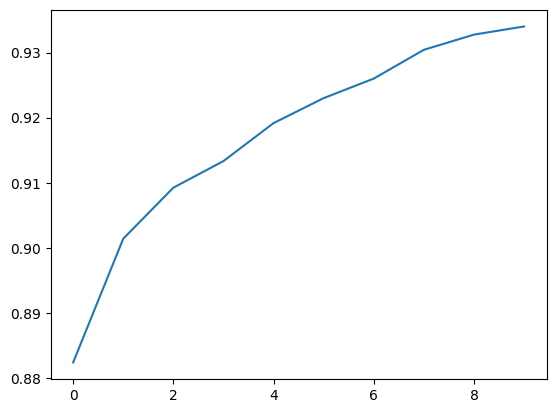

In [54]:
plt.plot(L(learn.recorder.values).itemgot(2));

And our final accuracy is:

In [55]:
learn.recorder.values[-1][2]

0.9340000152587891

In [56]:
def predict_image(x_batch, model):
    y_batch = model(x_batch)
    preds = torch.argmax(y_batch, dim=1)
    return(preds[0].item())

In [57]:
def predict_number(index):
    number_tensor =  torch.cat([training_set[index][0].view(-1, 784).float()/255])
    guess = predict_image(number_tensor, simple_nnet)
    print('Predicted Number: ', guess, ' Actual Number: ',training_set[index][1])
    

Predicted Number:  3  Actual Number:  3
Predicted Number:  9  Actual Number:  9
Predicted Number:  8  Actual Number:  8
Predicted Number:  6  Actual Number:  6
Predicted Number:  5  Actual Number:  5
Predicted Number:  5  Actual Number:  5
Predicted Number:  3  Actual Number:  3
Predicted Number:  6  Actual Number:  6
Predicted Number:  3  Actual Number:  3
Predicted Number:  2  Actual Number:  2


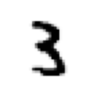

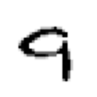

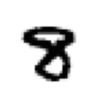

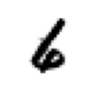

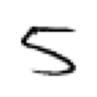

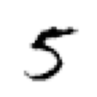

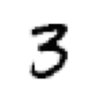

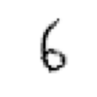

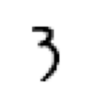

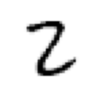

In [58]:
for i in range(10):
    index = np.random.randint(len(training_set))
    predict_number(index)
    show_image(training_set[index][0])